# MAIN ALGORITHM

1) Suppose (x1,y1) and (x2,y2) are the coordinates for inner and outer canthus points.

2) Euclidean distance between inner and outer canthus points is 
 𝐷𝐷((𝑥𝑥1, 𝑦𝑦1), (𝑥𝑥2, 𝑦𝑦2)) = √(x1 − x2)2 + (y1 − y2)2 
 
3) Calculate points Lp = (Lpx, Lpy)
Lpx = ( x1 + x2) /2 
Lpy = (y1+y2)/2 

4) Calculate top left (x3,y3)and bottom right (x4,y4) coordinate points of rectangular ROI
(x3, y3) = (Lpx − 1.2 x D , Lpy − 0.8 x D) 
(x4, y4) = (Lpx + 1.2 x D , Lpy + 0.8 x D)

5) Extract rectangular ROI with the above calculated points and resize all ROI images to the size of 224 X 224 X 3

In [97]:
import os
import shutil
import copy

from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image

import pickle
import math

In [98]:
ARTIFACT = 'D:/DATA_SCIENCE/biometrics/artifacts'

In [99]:
train = pd.read_pickle(os.path.join(ARTIFACT,'train.pkl'))
display(train.head())

,name,gender,corner_out_x,corner_out_y,corner_in_x,corner_in_y
0,C1_S1_I1.txt,Male,219,162,219,369
1,C1_S1_I2.txt,Male,225,179,227,368
2,C1_S1_I3.txt,Male,212,154,224,358
3,C1_S1_I4.txt,Male,237,176,251,401
4,C1_S1_I5.txt,Male,249,183,256,388


In [100]:
# applying this formula √(x1 − x2)2 + (y1 − y2)2
holder = ( (train['corner_in_x'] - train['corner_out_x'])**2 + 
                                (train['corner_in_y'] - train['corner_out_y'])**2 )
    

In [101]:
train['euclidean_distance'] = holder.apply(lambda x: math.sqrt(x))

In [102]:
# applying this formula Lpx = ( x1 + x2) /2 Lpy = (y1+y2)/2
train['lpx'] = ( train['corner_out_x'] + train['corner_in_x'] ) / 2
train['lpy'] = ( train['corner_out_y'] + train['corner_in_y'] ) / 2

In [103]:
# applying this formula (Lpx − 1.2 x D , Lpy − 0.8 x D) (x4, y4) = (Lpx + 1.2 x D , Lpy + 0.8 x D)
train['x3'] = train['lpx'] - 1.2 * train['euclidean_distance']                              
train['y3'] = train['lpy'] - 0.8 * train['euclidean_distance']

train['x4'] = train['lpx'] + 1.2 * train['euclidean_distance']
train['y4'] = train['lpy'] + 0.8 * train['euclidean_distance']

In [104]:
#renaming the columns to look more neat
renamed_columns = {'corner_in_x' : 'x1', 'corner_in_y' : 'y1', 'corner_out_x' : 'x2', 'corner_out_y' : 'y2'}
train.rename(columns = renamed_columns, inplace = True)

In [105]:
train['image'] = train['name'].apply(lambda x: x.split('.')[0] + '.jpg')

In [106]:
train.head()

,name,gender,x2,y2,x1,y1,euclidean_distance,lpx,lpy,x3,y3,x4,y4,image
0,C1_S1_I1.txt,Male,219,162,219,369,207.000000,219.0,265.5,-29.400000,99.900000,467.400000,431.100000,C1_S1_I1.jpg
1,C1_S1_I2.txt,Male,225,179,227,368,189.010582,226.0,273.5,-0.812698,122.291535,452.812698,424.708465,C1_S1_I2.jpg
2,C1_S1_I3.txt,Male,212,154,224,358,204.352636,218.0,256.0,-27.223164,92.517891,463.223164,419.482109,C1_S1_I3.jpg
3,C1_S1_I4.txt,Male,237,176,251,401,225.435135,244.0,288.5,-26.522162,108.151892,514.522162,468.848108,C1_S1_I4.jpg
4,C1_S1_I5.txt,Male,249,183,256,388,205.119477,252.5,285.5,6.356627,121.404418,498.643373,449.595582,C1_S1_I5.jpg


In [107]:
# dataframe statistics
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10199 entries, 0 to 10198
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                10199 non-null  object 
 1   gender              10199 non-null  object 
 2   x2                  10199 non-null  int32  
 3   y2                  10199 non-null  int32  
 4   x1                  10199 non-null  int32  
 5   y1                  10199 non-null  int32  
 6   euclidean_distance  10199 non-null  float64
 7   lpx                 10199 non-null  float64
 8   lpy                 10199 non-null  float64
 9   x3                  10199 non-null  float64
 10  y3                  10199 non-null  float64
 11  x4                  10199 non-null  float64
 12  y4                  10199 non-null  float64
 13  image               10199 non-null  object 
dtypes: float64(7), int32(4), object(3)
memory usage: 956.3+ KB


In [41]:
train.to_pickle('train_roi.pkl')

In [108]:
train['x3'] = train['x3'].astype('int')
train['y3'] = train['y3'].astype('int')
train['x4'] = train['x4'].astype('int')
train['y4'] = train['y4'].astype('int')

In [109]:
display(train.head())

,name,gender,x2,y2,x1,y1,euclidean_distance,lpx,lpy,x3,y3,x4,y4,image
0,C1_S1_I1.txt,Male,219,162,219,369,207.000000,219.0,265.5,-29,99,467,431,C1_S1_I1.jpg
1,C1_S1_I2.txt,Male,225,179,227,368,189.010582,226.0,273.5,0,122,452,424,C1_S1_I2.jpg
2,C1_S1_I3.txt,Male,212,154,224,358,204.352636,218.0,256.0,-27,92,463,419,C1_S1_I3.jpg
3,C1_S1_I4.txt,Male,237,176,251,401,225.435135,244.0,288.5,-26,108,514,468,C1_S1_I4.jpg
4,C1_S1_I5.txt,Male,249,183,256,388,205.119477,252.5,285.5,6,121,498,449,C1_S1_I5.jpg


In [13]:
IMG_DIR = 'D:/DATA_SCIENCE/biometrics/ubiperiocular_updated/images'

(-0.5, 437.5, 301.5, -0.5)

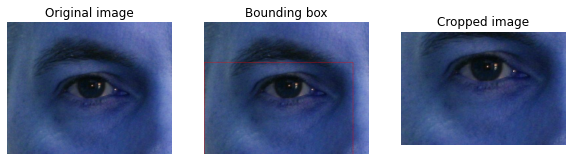

In [74]:
sample = cv2.imread(os.path.join(IMG_DIR,train.iloc[0,-1]), cv2.COLOR_BGR2RGB)
#sample_rect = cv2.rectangle(sample.copy(), (int(-0.812698), int(122.291535)), (int(452.812698), int(424.708465)), (255, 0, 0))
cropped_image = sample[99 : 431 , 29 : 467]

plt.figure(figsize = (10, 10))
plt.subplot(1, 3, 1)
plt.imshow(sample)
plt.title('Original image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_rect)
plt.title('Bounding box')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cropped_image)
plt.title('Cropped image')
plt.axis('off')

In [110]:
train['x3'] = train['x3'].apply(lambda x: 0 if x < 0 else x)
train['y3'] = train['y3'].apply(lambda x: 0 if x < 0 else x)
train['x4'] = train['x4'].apply(lambda x: 0 if x < 0 else x)
train['y4'] = train['y4'].apply(lambda x: 0 if x < 0 else x)

In [119]:
ROI_DIR = 'D:/DATA_SCIENCE/biometrics/ubiperiocular_updated/roi_images'

In [122]:
# extracting the roi by drawing bounding boxes around them
for i in range(0,train.shape[0]):
    img = cv2.imread(os.path.join(IMG_DIR,train.iloc[i,-1]), cv2.COLOR_BGR2RGB)
    p1, p2, p3, p4 = train.iloc[i,-4].astype('int'), train.iloc[i,-2].astype('int'), train.iloc[i,-5].astype('int'), train.iloc[i,-3].astype('int')
    cropped = img[p1:p2, p3:p4]
    cv2.imwrite(os.path.join(ROI_DIR,train.iloc[i,-1]), cropped)
    #print(cropped.shape)

# Resizing images

In [133]:
RESIZE_DIR = 'D:/DATA_SCIENCE/biometrics/ubiperiocular_updated/roi_resized'

In [137]:
#target = (224 * 224 * 3)
# resizing the images to 224*244*3
target_size = (224, 224)
images_list = list(os.listdir(ROI_DIR))
for x in range(len(os.listdir(ROI_DIR))):
    #print(os.path.join(ROI_DIR,images_list[x]))
    img = cv2.imread(os.path.join(ROI_DIR, images_list[x]))
    #print(img.shape)
    resized = cv2.resize(img, (target_size))
    cv2.imwrite(os.path.join(RESIZE_DIR,images_list[x]), resized)